In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
drivedir = 'drive/My Drive/Proyek Akhir NLP/'

# Load Dataset

In [ ]:
train_df = pd.read_csv(f'{drivedir}training_data.csv',index_col='id')
test_df = pd.read_csv(f'{drivedir}testing_data.csv',index_col='id')

display(train_df.head())
display(test_df.head())

,premis,hipotesis,label
id,,,
0,Ahli paleontologi Thomas MÃ¶rs dan timnya seda...,Thomas MÃ¶rs adalah ahli paleontologi .,entailment
1,Ahli paleontologi Thomas MÃ¶rs dan timnya seda...,Thomas MÃ¶rs memimpin timnya dengan baik .,neutral
2,Ahli paleontologi Thomas MÃ¶rs dan timnya seda...,Thomas MÃ¶rs seorang diri sedang dalam misi un...,contradiction
3,'Biaya yang diperlukan saat itu adalah sebesar...,Biaya yang diperlukan bernilai dolar saat itu,entailment
4,'Biaya yang diperlukan saat itu adalah sebesar...,Biaya itu belum terkumpul,netral


,premis,hipotesis
id,,
0,Barrichello dengan tangkas mengambil alih P1 d...,Barrichello menang
1,Barrichello dengan tangkas mengambil alih P1 d...,Barrichello mengambil alih P1
2,Wakil Bupati Ngawi Ony Anwar Harsono menilai B...,Benteng Pendem berpotensi untuk dijadikan cag...
3,Wakil Bupati Ngawi Ony Anwar Harsono menilai B...,Benteng Pendem ditemukan baru-baru ini
4,Wakil Bupati Ngawi Ony Anwar Harsono menilai B...,Benteng Pendem tidak berpotensi untuk dijadik...


In [ ]:
train_df['label'] = train_df['label'].apply(lambda x : x.lower())
train_df['label'] = train_df['label'].apply(lambda x : 'entailment' if x == 'entailments' else x)
train_df['label'] = train_df['label'].apply(lambda x : 'neutral' if x == 'netral' else x)

display(set(train_df['label']))

{'contradiction', 'entailment', 'neutral'}

# Preprocessing

In [ ]:
!pip install fuzzywuzzy
!pip install PySastrawi
!pip install num2words
!pip install catboost
!pip install python-Levenshtein
!git clone https://github.com/adnanzulkarnain/Tesaurus-Bahasa/
!git clone https://github.com/riochr17/Daftar-Antonim-Tesaurus-Bahasa-Indonesia/

     |████████████████████████████████| 215kB 10.7MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 64.8MB 45kB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144793 sha256=26385920f9563b321615f27b52bba18273342324b474046c2f8637be07fd9c2d
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein
Cloning into 'Tesaurus-Bahasa'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 40 (delta 17), reused 40 (delta 17), pack-reused 0
Unpacking objects: 100% (40/40), done.
Cloning into 'Daftar-Antonim-Tesaurus-Bahasa-Indonesia'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objec

In [ ]:
# sinonim

with open('Tesaurus-Bahasa/Tesaurus-BahasaIndonesia.txt') as f:
    lines = f.readlines()

lines = [x.strip().split(',') for x in lines]
lines = [x for x in lines if len(x) > 1]
synonym = dict()
for line in lines:
    resultant = line[0]
    for token in line:
        synonym[token] = resultant

synonym['tak'] = 'tidak'

# antonim

with open('Daftar-Antonim-Tesaurus-Bahasa-Indonesia/hasil-pasangan-antonim-id.txt') as f:
    lines = f.readlines()
lines = [x.strip().split() for x in lines]
from collections import defaultdict

antonym = defaultdict(set)
for line in lines:
    if line[0] not in antonym.keys():
        antonym[line[0]] = {line[1]}
    else:
        antonym[line[0]].add(line[1])
    if line[1] not in antonym.keys():
        antonym[line[1]] = {line[0]}
    else:
        antonym[line[1]].add(line[0])

def stem(df):
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    df['premis'] = df['premis'].apply(stemmer.stem)
    df['hipotesis'] = df['hipotesis'].apply(stemmer.stem)
    return df

def map2synonym(df, after_stem=False):
    def map2syn(row):
        res = []
        for tok in row.split():
            if tok in synonym.keys():
                res.append(synonym[tok])
            else:
                res.append(tok)
        return ' '.join(res)

    df['premis'] = df['premis'].apply(map2syn)
    df['hipotesis'] = df['hipotesis'].apply(map2syn)
    return df

def cont_antonym(df, after_stem=False):
    cont_antonym = []
    for p, h in zip(df['premis'],df['hipotesis']):
        ants = set()
        cnt = 0
        for tok in p.split():
            if tok in antonym.keys():
                for k in antonym[tok]:
                    ants.add(k)
        for ant in ants:
            if ant in h.split():
                cnt += 1
        cont_antonym.append(cnt)
    if after_stem:
        df['cont_antonym_stem'] = cont_antonym
    else:
        df['cont_antonym'] = cont_antonym
    return df

def lowercase(df):
    df['premis'] = df['premis'].apply(lambda x: x.lower())
    df['hipotesis'] = df['hipotesis'].apply(lambda x: x.lower())
    return df

def num2word(df):
    from num2words import num2words
    def num2word_row(row):
        sent = []
        for word in row.split():
            try:
                sent.append(num2words(int(word), lang='id'))
            except:
                sent.append(word)
        return ' '.join(sent)
    df['premis'] = df['premis'].apply(num2word_row)
    df['hipotesis'] = df['hipotesis'].apply(num2word_row)
    return df

def del_tanda(df):
    def del_tanda_row(row):
        return ''.join(ch for ch in row if ch.isalnum() or ch == ' ')
    df['premis'] = df['premis'].apply(del_tanda_row)
    df['hipotesis'] = df['hipotesis'].apply(del_tanda_row)
    return df

def extract_base_feats(df):
    df['intersect'] = [
        set(hip.split()).intersection(set(premis.split()))
        for hip, premis in zip(df['hipotesis'].values, df['premis'].values)
    ]
    df['p_len'] = df['premis'].apply(len)
    df['h_len'] = df['hipotesis'].apply(len)
    df['p_word_len'] = df['premis'].apply(lambda x: len(x.split()))
    df['h_word_len'] = df['hipotesis'].apply(lambda x: len(x.split()))
    df['p_unique_word_len'] = df['premis'].apply(lambda x: len(set(x.split())))
    df['h_unique_word_len'] = df['hipotesis'].apply(lambda x: len(set(x.split())))
    df['i_len'] = df['intersect'].apply(len)
    return df

def rat_feats(df):
    df['ph_len_rat'] = df['p_len'] / df['h_len']
    df['ph_word_len_rat'] = df['p_word_len'] / df['h_word_len']
    df['ph_unique_word_len_rat'] = df['p_unique_word_len'] / df['h_unique_word_len']
    df['ip_unique_word_len_rat'] = df['i_len'] / df['p_unique_word_len']
    df['ih_unique_word_len_rat'] = df['i_len'] / df['h_unique_word_len']
    return df

def neg_feats(df):
    def contains_neg(seq):
        cnt = 0
        for neg_token in ['bukan', 'tidak', 'tak', 'engga', 'enggak']:
            if neg_token in seq:
                cnt += 1
        return cnt
    df['p_contains_neg'] = df['premis'].apply(lambda x: contains_neg(x.split()))
    df['h_contains_neg'] = df['hipotesis'].apply(lambda x: contains_neg(x.split()))
    df['i_contains_neg'] = df['intersect'].apply(lambda x: contains_neg(x))
    return df

def pos_feats(df):
    def contains_pos(seq):
        cnt = 0
        for pos_token in ['adalah', 'merupakan', 'iyalah']:
            if pos_token in seq:
                cnt += 1
        return cnt
    df['p_contains_pos'] = df['premis'].apply(lambda x: contains_pos(x.split()))
    df['h_contains_pos'] = df['hipotesis'].apply(lambda x: contains_pos(x.split()))
    df['i_contains_pos'] = df['intersect'].apply(lambda x: contains_pos(x))
    return df

def fuzzy(df):
    from fuzzywuzzy import fuzz
    df['ratio'] = [fuzz.ratio(p,h) for p,h in zip(df['premis'],df['hipotesis'])]
    df['partial_ratio'] = [fuzz.partial_ratio(p,h) for p,h in zip(df['premis'],df['hipotesis'])]
    df['token_sort_ratio'] = [fuzz.token_sort_ratio(p,h) for p,h in zip(df['premis'],df['hipotesis'])]
    return df

def h_is_ordered_subs(df):
    is_ordered_subs = []
    for p, h, i in zip(df['premis'], df['hipotesis'], df['intersect']):
        if len(i) == 0:
            is_ordered_subs.append(0)
            continue

        i_list = []
        for p_t in p.split():
            if p_t in i:
                i_list.append(p_t)

        h_list = h.split()

        breaked = False
        for cnt, i_t in enumerate(i_list):
            if len(h_list) == 0:
                breaked = True
                is_ordered_subs.append((cnt)/len(i_list))
                break
            elif i_t in h_list:
                i_t_index = h_list.index(i_t)
                h_list = h_list[i_t_index+1:]
            else:
                breaked = True
                is_ordered_subs.append((cnt)/len(i_list))
                break

        if not breaked:
            is_ordered_subs.append(1)
    df['is_ordered_subs_num'] = is_ordered_subs
    df['is_ordered_subs_bool'] = df['is_ordered_subs_num'].apply(lambda x: 1 if x == 1 else 0)
    return df

def intersect_position(df):
    p_maxx = []
    p_minn = []
    p_meann = []
    h_maxx = []
    h_minn = []
    h_meann = []
    ph_minn = []
    ph_maxx = []
    ph_meann = []
    for p,h, i in zip(df['premis'], df['hipotesis'], df['intersect']):
        if len(i) == 0:
            p_maxx.append(0)
            p_minn.append(0)
            p_meann.append(0)
            h_maxx.append(0)
            h_minn.append(0)
            h_meann.append(0)
            ph_maxx.append(0)
            ph_minn.append(0)
            ph_meann.append(0)
            continue

        p_split = p.split()
        p_list = []
        for ii in i:
            p_list.append(p_split.index(ii))
        
        p_list = np.array(p_list)
        p_maxx.append(p_list.max())
        p_minn.append(p_list.min())
        p_meann.append(p_list.mean())

        h_split = h.split()
        h_list = []
        for ii in i:
            h_list.append(h_split.index(ii))
        
        h_list = np.array(h_list)
        h_maxx.append(h_list.max())
        h_minn.append(h_list.min())
        h_meann.append(h_list.mean())

        ph_maxx.append(h_list.max() - p_list.max())
        ph_minn.append(h_list.min() - p_list.min())
        ph_meann.append(h_list.mean() - p_list.mean())


    df['p_max'] = p_maxx
    df['p_min'] = p_minn
    df['p_mean'] = p_meann
    df['h_max'] = h_maxx
    df['h_min'] = h_minn
    df['h_mean'] = h_meann
    df['ph_max'] = ph_maxx
    df['ph_min'] = ph_minn
    df['ph_mean'] = ph_meann
    return df

from sklearn.preprocessing import StandardScaler
def normalize(train, test):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    test_data = scaler.transform(test)
    train = pd.DataFrame(data=train_data, index=train.index, columns=train.columns)
    test = pd.DataFrame(data=test_data, index=test.index, columns=test.columns)
    return train, test

def is_tidak(word):
    return word == 'tidak' \
        or word == 'tak' \
        or word == 'nggak' \
        or word == 'ngga' \
        or word == 'ga' \
        or word == 'gak' \
        or word == 'nda' \
        or word == 'ndak' \
        or word == 'bukan' \

def negasi_agreement(df, after_stem=False):
    negasi_agreement = []
    for p, h in zip(df['premis'],df['hipotesis']):
        word_after_tidak = ""
        h_tokens = h.split()
        n = len(h_tokens)
        for i, tok in enumerate(h_tokens):
            if is_tidak(tok) and i < n - 1:
                word_after_tidak = h_tokens[i + 1]
                break

        negasi = 0
        if word_after_tidak != "":
            p_tokens = p.split()
            n = len(p_tokens)
            for i, tok in enumerate(h_tokens):
                if word_after_tidak == tok and i > 0:
                    if is_tidak(h_tokens[i - 1]):
                        negasi = 1
            
        negasi_agreement.append(negasi)
    
    df['negasi_agreement'] = negasi_agreement
    return df

def unrelated_words(df, after_stem=False):
    unrelated_words = []
    for p, h in zip(df['premis'], df['hipotesis']):
        h_tokens = h.split()
        p_tokens = p.split()

        num_unrelated_word = 0
        for i, h_tok in enumerate(h_tokens):
            has_related = False
            if h_tok not in synonym:
                continue
                
            if is_tidak(h_tok):
                continue
            
            for j, p_tok in enumerate(p_tokens):
                if p_tok not in synonym:
                    continue
                
                if is_tidak(p_tok):
                    continue
                
                if synonym[h_tok] == synonym[p_tok]:
                    has_related = True
                    break
            
            if not has_related:
                num_unrelated_word += 1

        unrelated_words.append(num_unrelated_word)
    
    df['num_unrelated_words'] = unrelated_words
    return df


In [ ]:
# Feature Extraction

train_X = train_df[['premis','hipotesis']]
train_y = train_df['label']

train_X_temp = train_X.copy(deep=True)
test_X_temp = test_df.copy(deep=True)

train_X_temp = lowercase(train_X_temp)
test_X_temp = lowercase(test_X_temp)

train_X_temp = del_tanda(train_X_temp)
test_X_temp = del_tanda(test_X_temp)

# Buka ini jika menggunakan Embedding Tensorflow

# train_X_temp = map2synonym(train_X_temp)
# test_X_temp = map2synonym(test_X_temp)

# train_X_temp = stem(train_X_temp)
# test_X_temp = stem(test_X_temp)

# train_X_temp = map2synonym(train_X_temp, after_stem=True)
# test_X_temp = map2synonym(test_X_temp, after_stem=True)

train_X_temp = num2word(train_X_temp)
test_X_temp = num2word(test_X_temp)

train_X_use = train_X_temp.copy(deep=True)
test_X_use = test_X_temp.copy(deep=True)

display(train_X_use.head())
display(test_X_use.head())

,premis,hipotesis
id,,
0,ahli paleontologi thomas mãrs dan timnya sedan...,thomas mãrs adalah ahli paleontologi
1,ahli paleontologi thomas mãrs dan timnya sedan...,thomas mãrs memimpin timnya dengan baik
2,ahli paleontologi thomas mãrs dan timnya sedan...,thomas mãrs seorang diri sedang dalam misi unt...
3,biaya yang diperlukan saat itu adalah sebesar ...,biaya yang diperlukan bernilai dolar saat itu
4,biaya yang diperlukan saat itu adalah sebesar ...,biaya itu belum terkumpul


,premis,hipotesis
id,,
0,barrichello dengan tangkas mengambil alih p1 d...,barrichello menang
1,barrichello dengan tangkas mengambil alih p1 d...,barrichello mengambil alih p1
2,wakil bupati ngawi ony anwar harsono menilai b...,benteng pendem berpotensi untuk dijadikan caga...
3,wakil bupati ngawi ony anwar harsono menilai b...,benteng pendem ditemukan barubaru ini
4,wakil bupati ngawi ony anwar harsono menilai b...,benteng pendem tidak berpotensi untuk dijadika...


# Pembangunan Korpus untuk Tokenizer
Hanya digunakan jika menggunakan Embedding Tensorflow

In [ ]:
# corpus = train_X_use['premis'].values
# corpus = np.concatenate((corpus, train_X_use['hipotesis'].values))
# corpus = np.concatenate((corpus, test_X_use['premis'].values))
# corpus = np.concatenate((corpus, test_X_use['hipotesis'].values))

# display(corpus)

In [ ]:
# def encode_sentences(tokenizer, sentences):
#     result = []
#     for line in sentences:
#         result.append(tokenizer.texts_to_sequences([line])[0])
    
#     return np.array(result)

In [ ]:
# vocab_size = 7000
# oov_tok = '<OOV>'

# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(corpus)

# total_words = len(tokenizer.word_index) + 1

# enc_premis_train = encode_sentences(tokenizer, train_X_use['premis'].values)
# enc_hipotesis_train = encode_sentences(tokenizer, train_X_use['hipotesis'].values)
# enc_premis_test = encode_sentences(tokenizer, test_X_use['premis'].values)
# enc_hipotesis_test = encode_sentences(tokenizer, test_X_use['hipotesis'].values)

# display(enc_premis_train)
# display(enc_hipotesis_train)
# display(enc_premis_test)
# display(enc_hipotesis_test)

# Embedding Menggunakan Word2Vec
Hanya digunakan jika tidak menggunakan Embedding Tensorflow

In [ ]:
from gensim.models import Word2Vec

modelword2vec = Word2Vec.load(f'{drivedir}word2vec/idwiki_word2vec_300.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
!pip install stanza

     |████████████████████████████████| 194kB 12.0MB/s eta 0:00:01


In [ ]:
def encode_embed_single(modelword2vec, sentence):
    words = sentence.split()
    ans = []
    for i, w in enumerate(words):
        if w in modelword2vec:
            vec = modelword2vec[w]
            ans.append(vec)
        else:
            pass
    return np.array(ans)

def encode_embed(modelword2vec, sentences):
    ans = []
    for i, sentence in enumerate(sentences):
        vec = encode_embed_single(modelword2vec, sentence)
        ans.append(vec)
    return np.array(ans)

enc_premis_train = encode_embed(modelword2vec, train_X_use['premis'].values)
enc_hipotesis_train = encode_embed(modelword2vec, train_X_use['hipotesis'].values)
enc_premis_test = encode_embed(modelword2vec, test_X_use['premis'].values)
enc_hipotesis_test = encode_embed(modelword2vec, test_X_use['hipotesis'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# Padding Sequence Agar Berukuran Sama 

In [ ]:
max_sequence_len = 30

enc_premis_train = np.array(pad_sequences(enc_premis_train, maxlen=max_sequence_len, dtype='float64'))
enc_hipotesis_train = np.array(pad_sequences(enc_hipotesis_train, maxlen=max_sequence_len, dtype='float64'))
enc_premis_test = np.array(pad_sequences(enc_premis_test, maxlen=max_sequence_len, dtype='float64'))
enc_hipotesis_test = np.array(pad_sequences(enc_hipotesis_test, maxlen=max_sequence_len, dtype='float64'))

display(enc_premis_train.shape)
display(enc_hipotesis_train[:1])

(6726, 30, 100)

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.48866618,  0.22333029, -5.59925365, ..., -1.05732608,
          2.0856812 , -2.97090673],
        [-0.78160381, -6.00154066,  0.96326679, ...,  0.37162519,
          0.35521796,  0.36866537],
        [-0.07251085, -0.66207069, -0.23430449, ...,  0.24193813,
         -0.0676286 , -0.95855701]]])

# Ordinal Encode Kategori

In [ ]:
categories = list(set(train_y))
cat_map = {}
for i, c in enumerate(categories):
    cat_map[c] = i

train_y_ord = train_y.apply(lambda x : cat_map[x])
print(train_y_ord)

id
0       1
1       0
2       2
3       1
4       0
       ..
6721    0
6722    2
6723    1
6724    0
6725    2
Name: label, Length: 6726, dtype: int64


# Pembangunan Model

In [ ]:
def build_model():
    input_premis = tf.keras.Input(shape=(max_sequence_len, 100))
    input_hypot = tf.keras.Input(shape=(max_sequence_len, 100))

    # Hanya digunakan jika tidak menggunakan Word2Vec

    # token_embedding = tf.keras.layers.Embedding(total_words, 16, input_length = max_sequence_len)
    # premis_embed = token_embedding(input_premis)
    # hypot_embed = token_embedding(input_hypot)

    # dropout = tf.keras.layers.Dropout(0.4)
    # premis_embed = dropout(premis_embed)
    # hypot_embed = dropout(hypot_embed)

    cnn_layer = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=2,
        activation=tf.nn.relu)
    
    premis_seq_encode = cnn_layer(input_premis)
    hypot_seq_encode = cnn_layer(input_hypot)

    pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=4)
    premis_pool = pooling_layer(premis_seq_encode)
    hypot_pool = pooling_layer(hypot_seq_encode)

    # Uji Coba Penggantian Recurerent Unit
    # lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
    
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))
    premis_pool = lstm_layer(premis_pool)
    hypot_pool = lstm_layer(hypot_pool)

    z = tf.keras.layers.Concatenate()(
        [premis_pool, hypot_pool])
    
    z = tf.keras.layers.Dropout(0.4)(z)

    z = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2 * 64))(z)

    z = tf.keras.layers.Dense(128, activation=tf.nn.tanh)(z)
    z = tf.keras.layers.Dropout(0.3)(z)
    z = tf.keras.layers.Dense(32, activation=tf.nn.tanh)(z)
    z = tf.keras.layers.Dense(8, activation=tf.nn.tanh)(z)
    z = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(z)
    model = tf.keras.Model(inputs = [input_premis, input_hypot], outputs = z)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['acc']
    )

    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 100)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 100)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 29, 16)       3216        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 7, 16)        0           conv1d[0][0]                 

# Training Model

In [ ]:
from matplotlib import pyplot as plt

def train(model, train_dataset, valid_dataset):
    history = model.fit(
        x = train_dataset,
        # x = [enc_premis_train, enc_hipotesis_train],
        # y = train_y_ord,
        y = y_train,
        epochs = 40,
        batch_size=32,
        validation_data = valid_dataset
    )

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Loss', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    return history

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
        np.stack([enc_premis_train, enc_hipotesis_train], axis=1), train_y_ord, test_size = 0.2)

Epoch 1/40
169/169 [==============================] - 4s 22ms/step - loss: 1.0285 - acc: 0.4368 - val_loss: 0.9698 - val_acc: 0.4851
Epoch 2/40
169/169 [==============================] - 2s 13ms/step - loss: 0.9398 - acc: 0.5041 - val_loss: 0.9711 - val_acc: 0.4814
Epoch 3/40
169/169 [==============================] - 2s 13ms/step - loss: 0.9246 - acc: 0.5121 - val_loss: 0.9655 - val_acc: 0.4829
Epoch 4/40
169/169 [==============================] - 2s 14ms/step - loss: 0.9074 - acc: 0.5227 - val_loss: 0.9763 - val_acc: 0.4955
Epoch 5/40
169/169 [==============================] - 2s 13ms/step - loss: 0.8955 - acc: 0.5374 - val_loss: 0.9752 - val_acc: 0.4747
Epoch 6/40
169/169 [==============================] - 2s 14ms/step - loss: 0.8758 - acc: 0.5481 - val_loss: 1.0144 - val_acc: 0.4874
Epoch 7/40
169/169 [==============================] - 2s 13ms/step - loss: 0.8530 - acc: 0.5751 - val_loss: 1.0024 - val_acc: 0.4822
Epoch 8/40
169/169 [==============================] - 2s 13ms/step - 

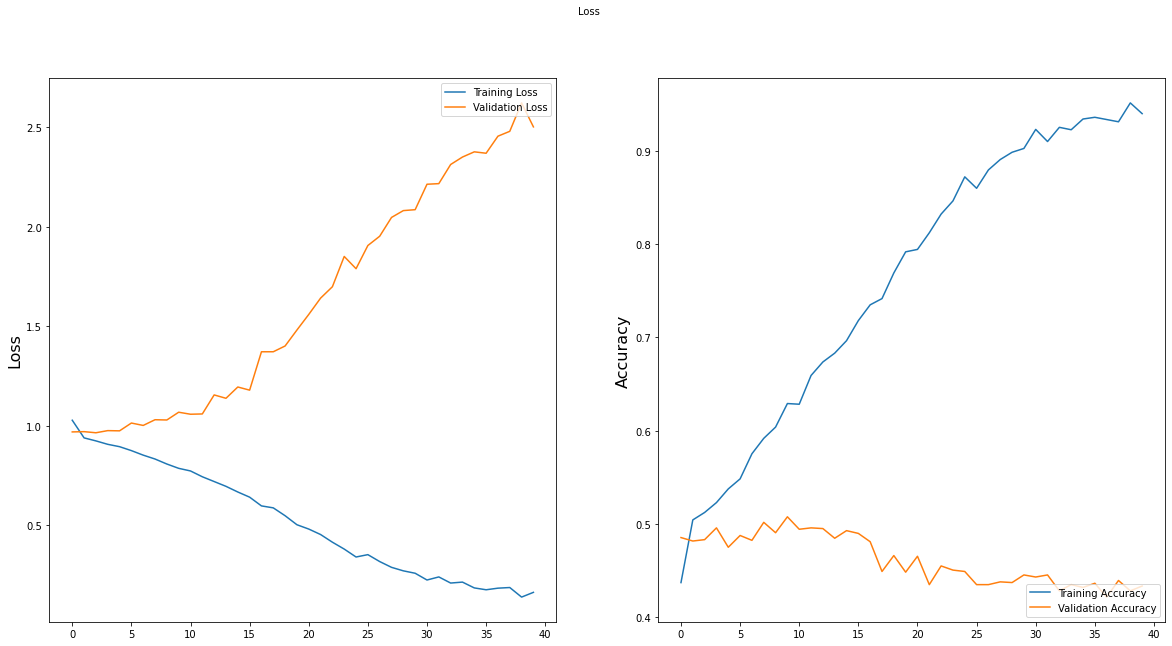

In [ ]:
history = train(model, [X_train[:, 0, :], X_train[:, 1, :]], ([X_val[:, 0, :], X_val[:, 1, :]], y_val))

# Pembuatan Prediksi

In [ ]:
preds = model.predict([enc_premis_test, enc_hipotesis_test])
preds = np.argmax(preds, axis=1)
print(preds)

[0 1 1 ... 1 1 2]


In [ ]:
preds = [categories[x] for x in preds]
print(preds)

['neutral', 'entailment', 'entailment', 'contradiction', 'contradiction', 'contradiction', 'entailment', 'entailment', 'neutral', 'entailment', 'entailment', 'neutral', 'entailment', 'neutral', 'contradiction', 'neutral', 'contradiction', 'entailment', 'contradiction', 'neutral', 'neutral', 'contradiction', 'contradiction', 'entailment', 'entailment', 'neutral', 'contradiction', 'entailment', 'contradiction', 'entailment', 'neutral', 'neutral', 'neutral', 'entailment', 'contradiction', 'neutral', 'neutral', 'entailment', 'neutral', 'neutral', 'neutral', 'entailment', 'contradiction', 'neutral', 'contradiction', 'neutral', 'contradiction', 'entailment', 'entailment', 'contradiction', 'entailment', 'entailment', 'contradiction', 'contradiction', 'entailment', 'entailment', 'entailment', 'neutral', 'entailment', 'neutral', 'neutral', 'contradiction', 'contradiction', 'entailment', 'entailment', 'contradiction', 'contradiction', 'neutral', 'neutral', 'neutral', 'entailment', 'entailment', 

In [ ]:
ans = pd.DataFrame(index=test_X_temp.index)
ans['label'] = preds

display(ans)

,label
id,
0,neutral
1,entailment
2,entailment
3,contradiction
4,contradiction
...,...
6988,contradiction
6989,contradiction
6990,entailment


# Export Hasil Prediksi Untuk Disubmit

In [ ]:
from datetime import datetime
from pytz import timezone    

asia_jakarta = timezone('Asia/Jakarta')
aj_time = datetime.now(asia_jakarta)
aj_time = aj_time.strftime('%Y-%m-%d_%H-%M-%S')
ans.to_csv(drivedir + 'submit_{}.csv'.format(aj_time), header=False)